In [123]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
from pyzbar import pyzbar
import re
from collections import defaultdict
from PyPDF2 import PdfFileReader, PdfFileWriter
from wand.image import Image
from wand.color import Color
import io
import warnings
from tqdm import tqdm
import math

plt.rcParams["figure.figsize"] = 20, 20

In [124]:
def read_pdf(filename, resolution=300):
    with open(filename, 'rb') as f:
        pdf_file = PdfFileReader(f)            
        for i, page in enumerate(pdf_file.pages):
            pdf_bytes = io.BytesIO()
            writer = PdfFileWriter()
            writer.addPage(page)
            writer.write(pdf_bytes)
            pdf_bytes.seek(0)
            with Image(file=pdf_bytes, resolution=resolution) as img:
                img.background_color = Color('white')
                img.alpha_channel = 'remove'
                img_buffer = np.asarray(bytearray(img.make_blob('bmp')), dtype=np.uint8)
                if img_buffer is not None:
                    yield cv2.imdecode(img_buffer, cv2.IMREAD_UNCHANGED)

# this seems to be slower, actually to be tested
def read_pdf_new(filename, resolution=300):
    image_pdf = Image(filename=filename, resolution=resolution)
    image_bmp = image_pdf.convert('bmp')
    for img in image_bmp.sequence:
        img.background_color = Color('white')
        img.alpha_channel = 'remove'
        img_buffer = np.asarray(bytearray(Image(image=img).make_blob('bmp')), dtype=np.uint8)
        yield cv2.imdecode(img_buffer, cv2.IMREAD_UNCHANGED)

In [244]:
def prepare_omr_roi(image, highlight=True, offset=5):
    def decode_bottom_right(data, image_diag):
        m = re.search(r'\((?P<x0>\d+),(?P<y0>\d+)\)-\((?P<x1>\d+),(?P<y1>\d+)\)/(?P<diag>\d+)/(?P<size>\d+),(?P<page>\d+)(?:,(?P<start>\d+)-(?P<end>\d+))?', data)
        if not m:
            raise RuntimeError("Bottom-right qrcode encoded information do not comply with the expected format:\nfound {}".format(data))
            
        p0, p1 = np.array([m.group('x0'), m.group('y0')], dtype=float), np.array([m.group('x1'), m.group('y1')], dtype=float)
        diag = int(m.group('diag'))
        # rescale the bounding box of the roi to pixel coordinates
        p0 = (p0 * (image_diag / diag) + 0.5).astype(int)
        p1 = (p1 * (image_diag / diag) + 0.5).astype(int)    
        size = int(m.group('size')) * image_diag / diag
        
        return { 'p0': p0, 
                 'p1': p1, 
                 'diag': diag, 
                 'diag_ratio': image_diag / diag,
                 'bubble_size': size, 
                 'bubble_area': size * size * np.pi / 4.0,
                 'page': int(m.group('page')), 
                 'range': (int(m.group('start')), int(m.group('end')))
               }
    def decode_top_left(data):
        m = re.search(r'(?P<id>\d+),(?P<date>\d+/\d+/\d+),\[(?P<sequence>[^\]]+)\]', data)
        if not m:
            raise RuntimeError("Top-left qrcode encoded information do not comply with the expected format:\nfound {}".format(data))
        return { 
            'student_id': m.group('id'),
            'date': m.group('date'),
            'correct': m.group('sequence').split(',') if m.group('sequence') else []
        }
    
    # assumes the image has the right orientation 
    _retval, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    qrcodes = pyzbar.decode(binary)
    
    assert len(qrcodes) == 2, "Each page should have exactly two qrcodes, found {}".format(len(qrcodesbarcodes))
    # sort the two qrcodes so that the top-leftmost is the first and the bottom-rightmost is the second
    qrcodes.sort(key=lambda b: b.rect[0])
    
    if highlight:
        for qrcode in qrcodes:
            # extract the bounding box location of the qrcode and draw a green 
            # frame around them
            (x, y, w, h) = qrcode.rect
            cv2.rectangle(image, (x - offset, y - offset), (x + w + offset, y + h + offset), (0, 255, 0), 3)
            
    # crop the image just to the qrcodesbarcodes
    tl = np.array(qrcodes[0].rect[:2])
    br = np.array(qrcodes[1].rect[:2]) + np.array(qrcodes[1].rect[2:])
    image = image[tl[1]:br[1], tl[0]:br[0]]        
    
    # extract information from the qrcodes
    metadata = { 
        **decode_top_left(str(qrcodes[0].data)),
        **decode_bottom_right(str(qrcodes[1].data), np.linalg.norm(image.shape[:2])),
    }
    roi = image[metadata['p0'][1]:metadata['p1'][1], metadata['p0'][0]:metadata['p1'][0]]        
    if highlight:
        # draw a frame around the omr area
        cv2.rectangle(image, tuple(metadata['p0'] - offset), tuple(metadata['p1'] + offset), (0, 0, 255), 3)
    # determine the range of the questions that are present in the current page
    if metadata['range'][0] is not None and metadata['range'][1] is not None:
        metadata['correct'] = metadata['correct'][metadata['range'][0] - 1:metadata['range'][1]]
    else:
        warnings.warn('No answer on page {}'.format(metadata['page']))
    # the data returned are:
    # - the image
    # - the omr roi
    # - the subsequence of correct answers for the questions appearing in the current page
    # - the list of the questions appearing in the current page
    return image, roi, metadata

In [245]:
def process_page(page, highlight=True, offset=5):
    def circle_filled_area(image, c):
        area = 0
        center = np.array([c[0], c[1]])
        radius = c[2]
        xbounds = range(max(0, c[0] - c[2]), min(image.shape[1], c[0] + c[2] + 1))
        ybounds = range(max(0, c[1] - c[2]), min(image.shape[0], c[1] + c[2] + 1))
        for y in ybounds:
            for x in xbounds:
                point = np.array([x, y])
                if cv2.norm(point - center) <= radius and image[y, x] > 0:
                    area += 1
        return area
    # get the prepared data, including the omr_roi
    image, omr_roi, metadata = prepare_omr_roi(page)
    if metadata['correct'] is None and metadata['range'] is None: # there is no answer on current page
        return []
    # in order to detect the contours in the omr_roi, a blur and an adaptive thresholding is used
    if len(omr_roi.shape) > 2:
        gray = cv2.cvtColor(omr_roi, cv2.COLOR_BGR2GRAY) 
    else:
        gray = omr_roi
    gray = cv2.GaussianBlur(gray, (5, 5), 2)
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    # get the contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # try to construct the circles
    circles = []
    # for each detcted contour
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        # try to simplify it
        approx = cv2.approxPolyDP(contour, 0.01 * perimeter, True)
        # and check whether it is a candidate to be a circle (in that case append it)
        if len(approx) >= 8:                        
            (cx, cy), radius = cv2.minEnclosingCircle(contour)        
            area = radius * radius * np.pi
            if  metadata['bubble_area'] * 0.75 <= area <= metadata['bubble_area'] * 1.5:
                circles.append((int(cx), int(cy), int(radius)))
                if highlight:
                    p0 = (int(cx - radius - offset), int(cy - radius - offset))
                    p1 = (int(cx + radius + offset), int(cy + radius + offset))
                    cv2.rectangle(omr_roi, p0, p1, (255, 102, 0), 3)
    # sort circles according to the x component (leftmost first, topmost after)
    circles = sorted(circles)
    # identify the reference_circles first, assuming the leftmost/topmost is the reference one
    pivot = circles[0]
    # the reference circles are those whose center is almost in the same column as the pivot
    reference_circles = [c for c in circles if abs(c[0] - pivot[0]) <= pivot[2]]
    # all the other are the answer circles
    other_circles = [c for c in circles if abs(c[0] - pivot[0]) > pivot[2]]
    # highlight the reference circles if required
    if highlight:
        for c in reference_circles:
            cv2.circle(omr_roi, c[:2], c[2], (0, 255, 255), 3)
    # compute the mean area of the referene circles (helping to identify the filled ones later)
    mean_area = np.mean(np.fromiter((c[2] * c[2] * np.pi for c in reference_circles), np.float))
    # maintain the information as a mapping between the reference circle and all the
    # answer circles on the same row
    answer_circles = defaultdict(lambda: [])
    # process the answer circles
    for c in other_circles:
        # find the closest reference circle, w.r.t. y coordinate
        ydist = np.fromiter((abs(c[1] - rc[1]) for rc in reference_circles), int)
        reference_circle = reference_circles[np.argmin(ydist)]
        # compute the filled area within the circle
        filled_area = circle_filled_area(binary, c)
        # if the circle is at least half-full, then append it to the reference one and
        # mark it as an answer (the boolean at lat)
        if filled_area / mean_area > 0.6: # before was 0.4
            answer_circles[reference_circle].append(c + (True,))
        else:
            answer_circles[reference_circle].append(c + (False,))
    # now consider each reference circle from the topmost one down
    answer_circles = sorted(answer_circles.items(), key=lambda item: item[0][1])
    # check whether questions and the expected sequence of answers match
    if len(answer_circles) > len(metadata['correct']):
        raise RuntimeError("Not enough answers {}".format(metadata['correct']))
    # go through the questions (reference circles) and check the answers
    correction = []
    for i, ac in enumerate(answer_circles):
        correct_res = set(metadata['correct'][i])
        all_res = set()
        answers_res = set()    
        for j, c in enumerate(ac[1]):
            r = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"[j]
            all_res.add(r)
            if c[3]:
                answers_res.add(r)
                if r in correct_res and highlight:
                    cv2.circle(omr_roi, c[:2], c[2], (0, 255, 0), 5)
                elif highlight:
                    cv2.circle(omr_roi, c[:2], c[2], (255, 0, 0), 5)
            else:
                if r in correct_res and highlight:
                    cv2.circle(omr_roi, c[:2], c[2], (255, 0, 0), 5)
        # check if there are missing answers on the paper-sheet
        missing_answers = correct_res - all_res
        if len(missing_answers) > 0:
            warnings.warn("For question {}, the correct answer{} {} {} not printed on the sheet".format(metadata['correct'][i], "s" if len(missing_answers) > 1 else "", missing_answers, "were" if len(missing_answers) > 1 else "was"))
            ytop = int(ac[0][1] - 1.3 * ac[0][2])
            ybottom = int(ac[0][1] + 1.3 * ac[0][2])
            if highlight:
                cv2.rectangle(omr_roi, (0, ytop), (omr_roi.shape[1], ybottom), (255, 0, 0), 7)
            p = np.array(ac[0][0:2]) + [-ac[0][2], -ac[0][2] - 40]
            cv2.putText(omr_roi, "Missing answer(s) {}".format(missing_answers), tuple(p), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)
        if highlight:
            # write a text with the given answers and the correct ones close to each reference circle
            p = np.array(ac[0][0:2]) + [-ac[0][2], ac[0][2] + 40]
            tmp = "".join(a for a in answers_res) if answers_res else "None"
            tmp += "/" + "".join(a for a in correct_res)
            cv2.putText(omr_roi, tmp, tuple(p), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
        correction.append((answers_res, correct_res))
    return correction

In [246]:
def check_answer_correctness(correction, **kwargs):
    marking = []
    for question in correction:
        correct_rate = len(question[0] & question[1]) / len(question[1])
        wrong_rate = len(question[0] - question[1]) / len(question[1])
        marking.append((2.0 * correct_rate - wrong_rate) / 2.0)
    return marking

In [247]:
def run(filename="prova_scansione.pdf", **kwargs):
    pdf = read_pdf(filename)
    for i, page in enumerate(pdf):
        if 'only' in kwargs and i != kwargs['only'] - 1:
            continue
        correction = process_page(page)
        print(correction)  
    #    print(correction)
        plt.imshow(page)

False
[({'B'}, {'A'}), ({'C'}, {'B', 'C'}), ({'D', 'A'}, {'A'})]
False
[({'B', 'D'}, {'D'})]


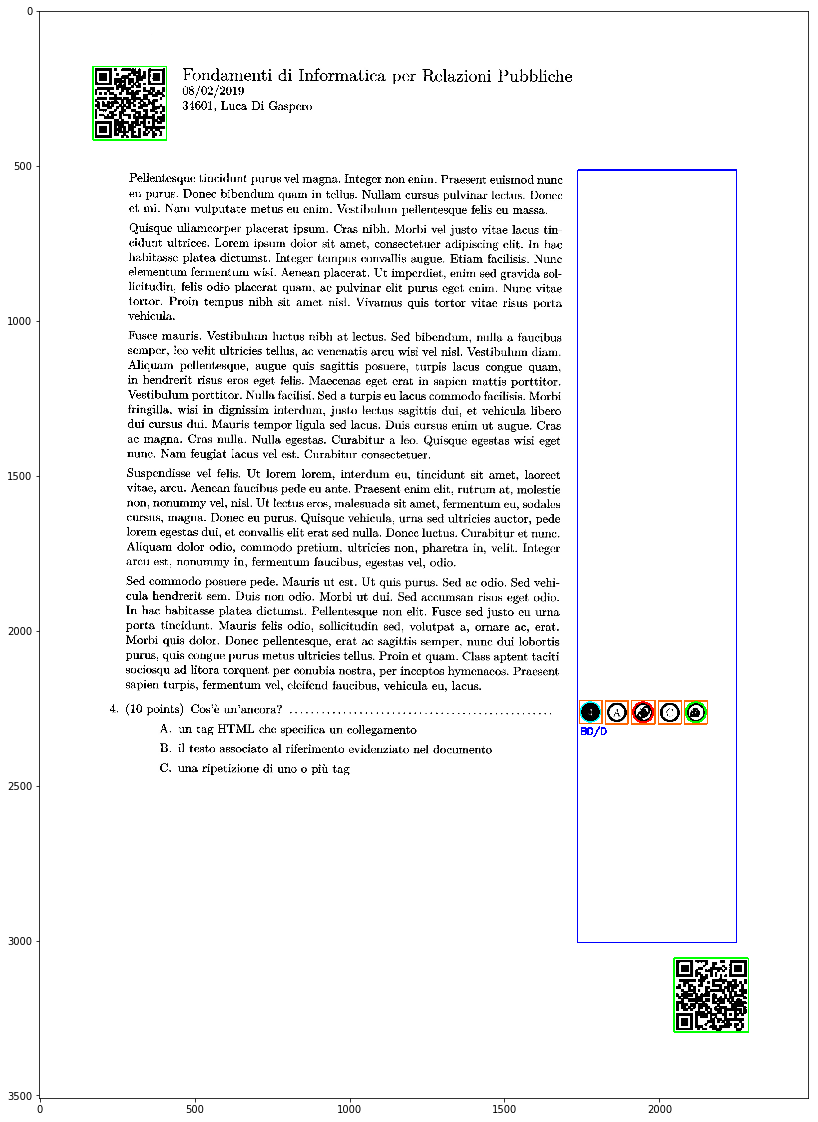

In [248]:
run()